In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_parallelise as u_par
import datetime
import salem
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
import shapely.geometry as shpg
import glob
import pickle as pkl
import os
import multiprocessing
from metpy import calc
from metpy.units import units

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
da_hist = xr.open_dataset(cnst.network_data+'data/LMCS/MCS_files/CP4_box/mean_09_hist.nc')
da_fut = xr.open_dataset(cnst.network_data+'data/LMCS/MCS_files/CP4_box/mean_09_fut.nc')

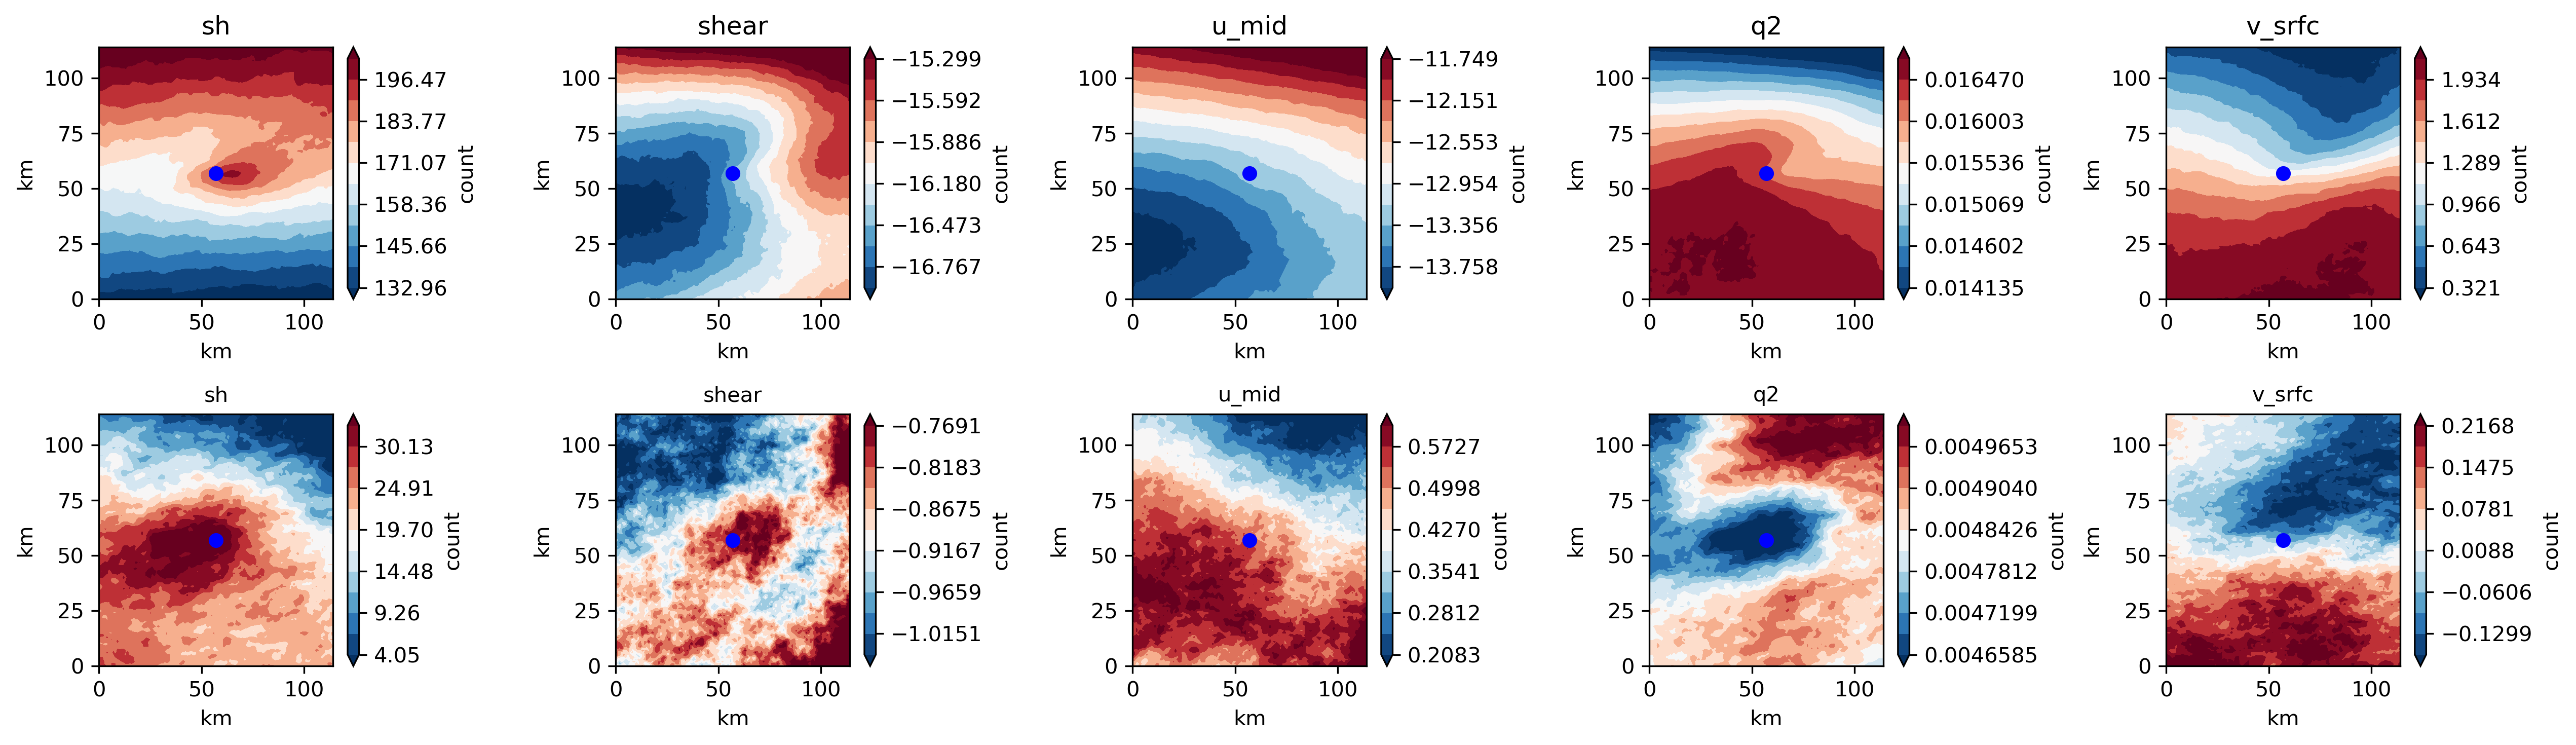

In [531]:
f = plt.figure(figsize=(17,5), dpi=300)
mname = 'node'
extent = 57 #* 4.4

for ix, var in enumerate(['sh', 'shear', 'u_mid', 'q2', 'v_srfc']):
    
    ax = f.add_subplot(2,5,ix+1)

    ano = da_hist[var]#.mean('cases')

    thresh = np.max(np.abs(np.percentile(ano, [5, 95])))
    threshmh = np.percentile(ano, [5, 95])

    plt.contourf(ano, cmap='RdBu_r', extend='both', levels=np.linspace(threshmh[0], threshmh[1], 12)) #levels=np.linspace(thresh * -1, thresh, 10)
    
    plt.plot(extent, extent, 'bo')
    #ax.set_xticklabels(np.arange(116,20)-115)
    #ax.set_xticks((np.linspace(0, 2 * extent, 9)))
    #ax.set_xticklabels(((np.linspace(0, (2 * extent), 9) - extent)*0.25).round(1).astype(float))
    #ax.set_yticks((np.linspace(0, 2 * extent, 9)))
    #ax.set_yticklabels(((np.linspace(0, (2 * extent), 9) - extent)*0.25).round(1).astype(float))
    ax.set_xlabel('km')
    ax.set_ylabel('km')
    #ax.axvline(extent, linestyle='dashed', color='k')
    #ax.axhline(extent, linestyle='dashed', color='k')

#     rect = patches.Rectangle((5.5, 5.5), 11, 11, linewidth=0.5, edgecolor='k', facecolor='none')
#     ax.add_patch(rect)

    plt.colorbar(label='count')
    plt.title(var)
    #plt.title(regs+' day 0 initiations',  fontsize=10)
    
    
    ax = f.add_subplot(2,5,ix+1+5)

    ano = da_fut[var]-da_hist[var]

    thresh = np.max(np.abs(np.percentile(ano, [5,95])))
    threshm = np.percentile(ano, [5, 95])

    plt.contourf(ano, cmap='RdBu_r', extend='both', levels=np.linspace(threshm[0], threshm[1], 12))
    plt.plot(extent, extent, 'bo')
    #ax.set_xticks((np.linspace(0, 2 * extent, 9)))
    #ax.set_xticklabels(((np.linspace(0, (2 * extent), 9) - extent)*0.25).round(1).astype(float))
    #ax.set_yticks((np.linspace(0, 2 * extent, 9)))
    #ax.set_yticklabels(((np.linspace(0, (2 * extent), 9) - extent)*0.25).round(1).astype(float))
    ax.set_xlabel('km')
    ax.set_ylabel('km')
    #ax.axvline(extent, linestyle='dashed', color='k')
    #ax.axhline(extent, linestyle='dashed', color='k')

#     rect = patches.Rectangle((5.5, 5.5), 11, 11, linewidth=0.5, edgecolor='k', facecolor='none')
#     ax.add_patch(rect)

    plt.colorbar(label='count')
    plt.title(var)
    plt.title(var,  fontsize=10)
    
plt.tight_layout()
#f.savefig(cnst.network_data + 'figs/LSTA/corrected_LSTA/new/wavelet_coefficients/2hOverlap/maps.png')

In [6]:
def calc_div(da):
    u = units.Quantity(da['u_srfc'].values, 'm/s')
    v = units.Quantity(da['v_srfc'].values, 'm/s')
    
    dx = units.Quantity(4400, 'm')
    div = calc.divergence(u,v, dx, dx)
    # vort = calc.shearing_deformation(u,v, dx, dx)
    da_div = da['sh'].copy(deep=True)
    da_div.values = div
    
    return da_div

In [7]:
def calc_div_mid(da):
    u = units.Quantity(da['u_mid'].values, 'm/s')
    v = units.Quantity(da['v_mid'].values, 'm/s')
    
    dx = units.Quantity(4400, 'm')
    div = calc.divergence(u,v, dx, dx)
    # vort = calc.shearing_deformation(u,v, dx, dx)
    da_div = da['sh'].copy(deep=True)
    da_div.values = div
    
    return da_div

In [8]:
def calc_theta(da):    
    p = units.Quantity(925, 'hPa')
    t = units.Quantity(da['t_srfc'].values+273.15, 'K')
    q = units.Quantity(da['q_srfc'].values/1000, 'kg/kg')
    
    p_up = units.Quantity(650, 'hPa')
    t_up = units.Quantity(da['t_mid'].values+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p_up,t_up))
    
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
     
    thetae = thetae_down -thetaes_up 
    
    da_theta = da['sh'].copy(deep=True)
    da_theta.values = thetae
    
  #  ipdb.set_trace()
    
    return da_theta

In [3]:
da_hist_anom = xr.open_mfdataset(cnst.network_data+'data/LMCS/MCS_files/CP4_box/anomMean_*_hist.nc', concat_dim='month', combine="nested").load().mean('month')
da_fut_anom = xr.open_mfdataset(cnst.network_data+'data/LMCS/MCS_files/CP4_box/anomMean_*_fut.nc', concat_dim='month', combine="nested").load().mean('month')

In [4]:
da_hist = xr.open_mfdataset(cnst.network_data+'data/LMCS/MCS_files/CP4_box/mean_*_hist.nc', concat_dim='month', combine="nested").load().mean('month')
da_fut = xr.open_mfdataset(cnst.network_data+'data/LMCS/MCS_files/CP4_box/mean_*_fut.nc', concat_dim='month', combine="nested").load().mean('month')

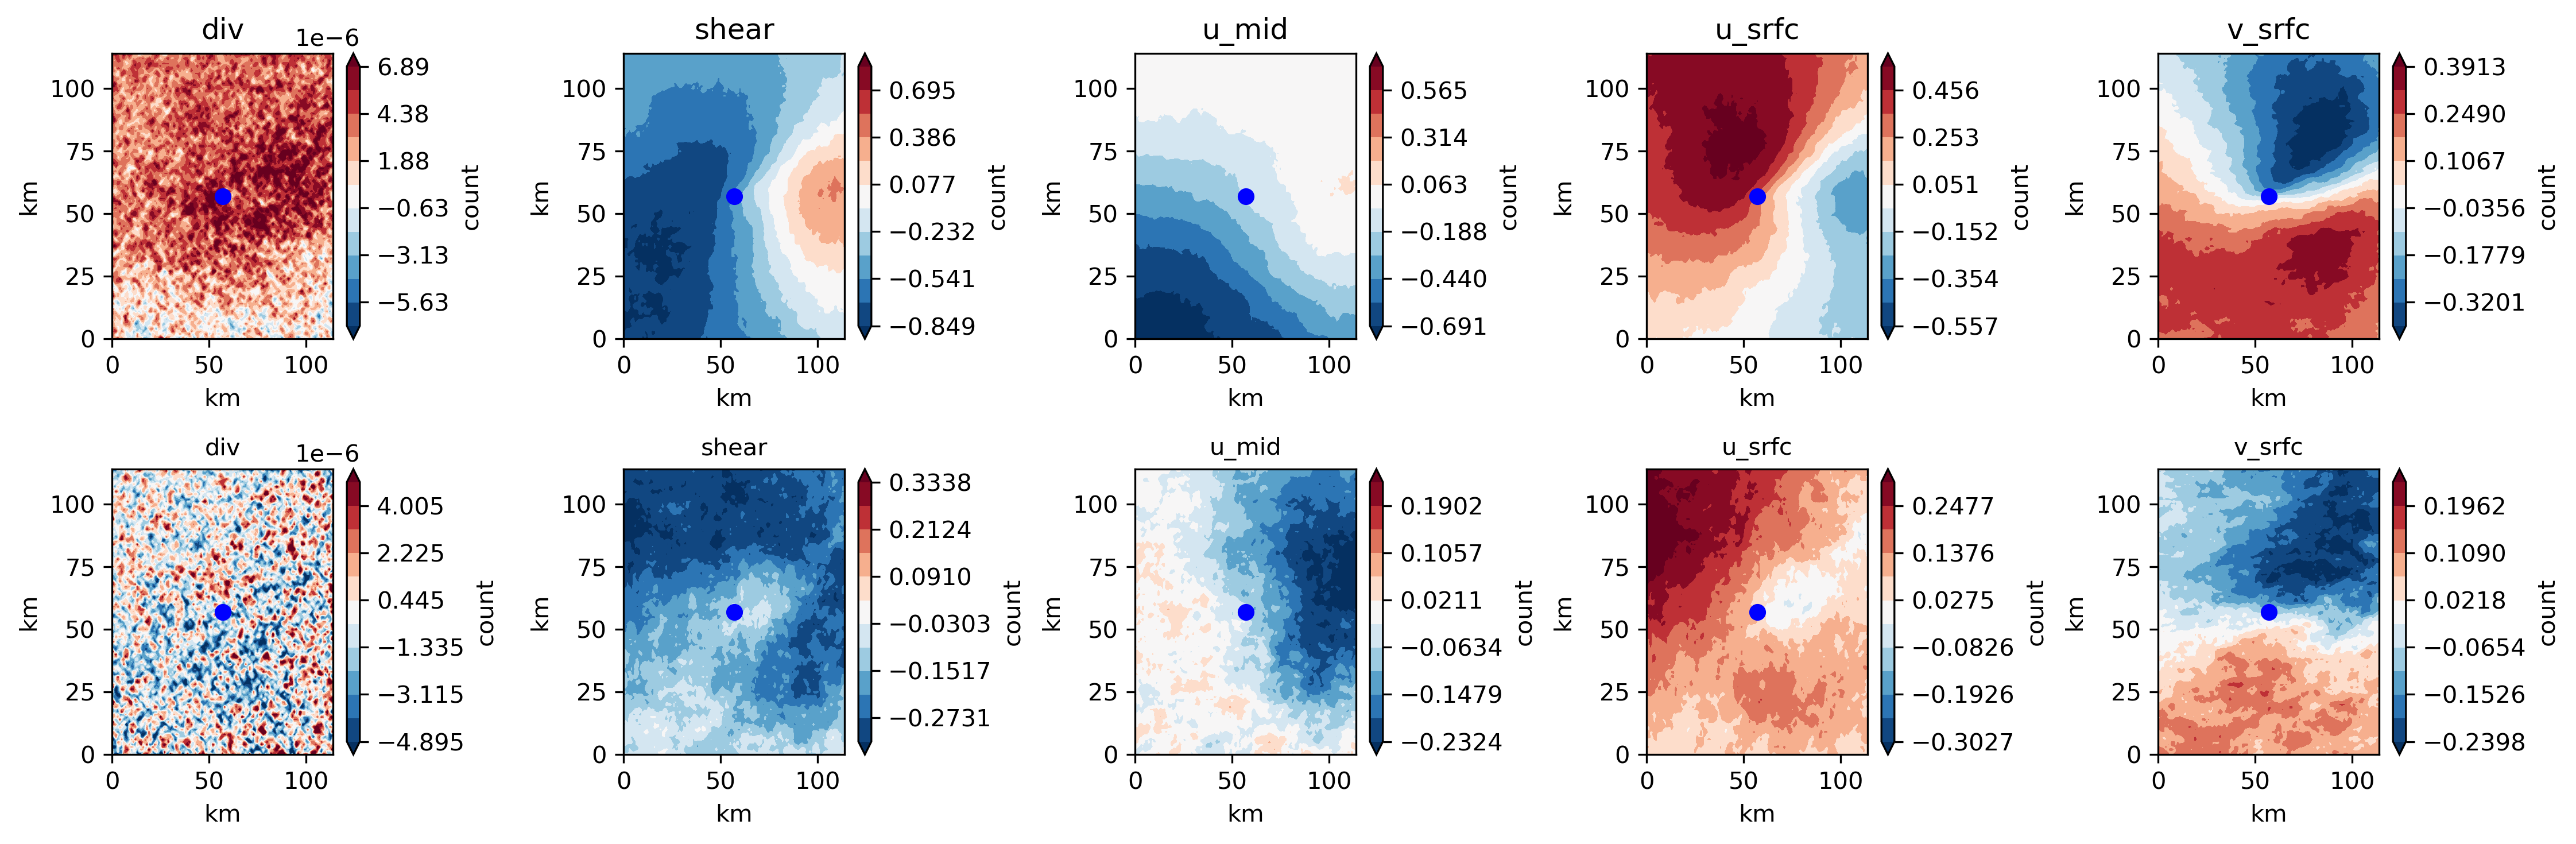

In [530]:
f = plt.figure(figsize=(15,5), dpi=300)
mname = 'node'
extent = 57 #* 4.4

for ix, var in enumerate(['div', 'shear', 'u_mid', 'u_srfc', 'v_srfc']):
    
    ax = f.add_subplot(2,5,ix+1)


    if var == 'div':
        ano = calc_div_mid(da_hist)
    else:
        ano = da_hist_anom[var]#.mean('cases')

    thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

    plt.contourf(ano, cmap='RdBu_r', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
    
    plt.plot(extent, extent, 'bo')
    #ax.set_xticklabels(np.arange(116,20)-115)
    #ax.set_xticks((np.linspace(0, 2 * extent, 9)))
    #ax.set_xticklabels(((np.linspace(0, (2 * extent), 9) - extent)*0.25).round(1).astype(float))
    #ax.set_yticks((np.linspace(0, 2 * extent, 9)))
    #ax.set_yticklabels(((np.linspace(0, (2 * extent), 9) - extent)*0.25).round(1).astype(float))
    ax.set_xlabel('km')
    ax.set_ylabel('km')
    #ax.axvline(extent, linestyle='dashed', color='k')
    #ax.axhline(extent, linestyle='dashed', color='k')

#     rect = patches.Rectangle((5.5, 5.5), 11, 11, linewidth=0.5, edgecolor='k', facecolor='none')
#     ax.add_patch(rect)

    plt.colorbar(label='count')
    plt.title(var)
    #plt.title(regs+' day 0 initiations',  fontsize=10)
    
    
    ax = f.add_subplot(2,5,ix+1+5)
    
    if var == 'div':
        ano = calc_div_mid(da_fut)-calc_div_mid(da_hist)
    else:
         ano = da_fut_anom[var]-da_hist_anom[var]
   
    thresh = np.max(np.abs(np.percentile(ano, [5,95])))

    plt.contourf(ano, cmap='RdBu_r', extend='both', levels=np.linspace(thresh * -1, thresh, 12))
    plt.plot(extent, extent, 'bo')
    #ax.set_xticks((np.linspace(0, 2 * extent, 9)))
    #ax.set_xticklabels(((np.linspace(0, (2 * extent), 9) - extent)*0.25).round(1).astype(float))
    #ax.set_yticks((np.linspace(0, 2 * extent, 9)))
    #ax.set_yticklabels(((np.linspace(0, (2 * extent), 9) - extent)*0.25).round(1).astype(float))
    ax.set_xlabel('km')
    ax.set_ylabel('km')
    #ax.axvline(extent, linestyle='dashed', color='k')
    #ax.axhline(extent, linestyle='dashed', color='k')

#     rect = patches.Rectangle((5.5, 5.5), 11, 11, linewidth=0.5, edgecolor='k', facecolor='none')
#     ax.add_patch(rect)

    plt.colorbar(label='count')
    plt.title(var)
    plt.title(var,  fontsize=10)
    
plt.tight_layout()
#f.savefig(cnst.network_data + 'figs/LSTA/corrected_LSTA/new/wavelet_coefficients/2hOverlap/maps.png')

In [332]:
da_hist

<xarray.Dataset>
Dimensions:        (latitude: 115, longitude: 115)
Coordinates:
  * longitude      (longitude) float64 -57.0 -56.0 -55.0 ... 55.0 56.0 57.0
  * latitude       (latitude) float64 -57.0 -56.0 -55.0 -54.0 ... 55.0 56.0 57.0
Data variables:
    lw_out_PBLtop  (latitude, longitude) float64 -61.12 -60.37 ... -57.2 -57.54
    lsRain         (latitude, longitude) float64 1.299 1.029 ... 0.7087 0.5442
    shear          (latitude, longitude) float32 -16.54566 ... -14.672765
    u_mid          (latitude, longitude) float32 -13.830215 ... -11.199991
    u_srfc         (latitude, longitude) float32 2.6781306 ... 3.2103739
    v_mid          (latitude, longitude) float32 -1.4469807 ... -0.5380201
    v_srfc         (latitude, longitude) float32 2.056143 ... 0.3375665
    q_mid          (latitude, longitude) float64 6.067 6.068 ... 5.178 5.177
    t_mid          (latitude, longitude) float64 5.573 5.572 ... 6.23 6.233
    t_srfc         (latitude, longitude) float64 23.65 23.65 ... 28.72 28.74
    q_srfc         (latitude, longitude) float64 15.22 15.22 ... 12.68 12.66
    geoH_srfc      (latitude, longitude) float64 782.3 782.3 ... 773.1 773.1
    tcwv           (latitude, longitude) float64 46.35 46.37 ... 38.31 38.27
    sh             (latitude, longitude) float64 131.6 130.6 ... 204.2 204.4
    lh             (latitude, longitude) float64 290.1 290.2 ... 166.1 165.7
    t2             (latitude, longitude) float64 301.9 301.9 ... 307.4 307.4
    q2             (latitude, longitude) float64 0.01669 0.0167 ... 0.0134
    lsRain_noon    (latitude, longitude) float64 1.715e-05 ... 9.501e-06
    lwout_noon     (latitude, longitude) float64 -12.16 -12.19 ... -5.228 -5.209
    SM             (latitude, longitude) float64 15.57 15.6 ... 6.569 6.557

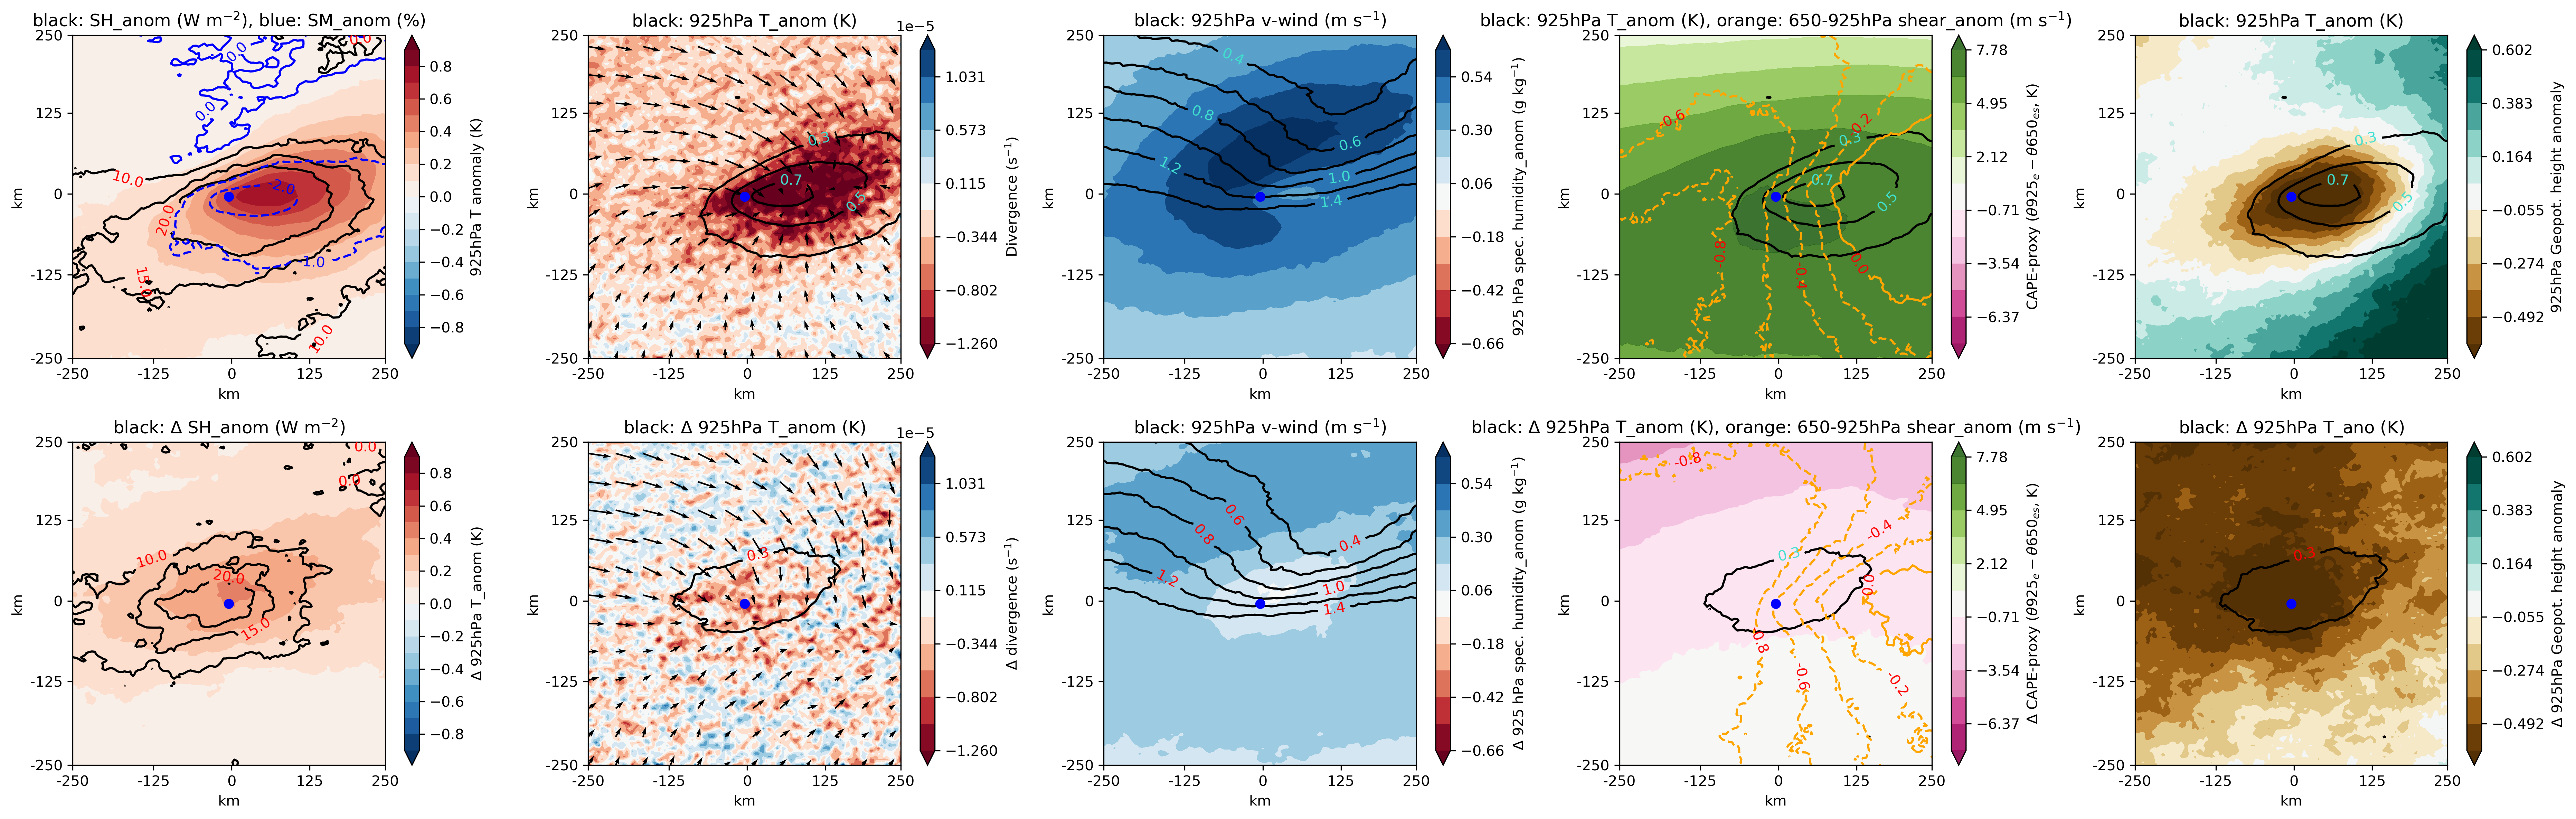

In [532]:
f = plt.figure(figsize=(25,8), dpi=300)
mname = 'node'
extent = 57 #* 4.4

ticks = np.array([0,58-57/2,58,58+57/2,114])
#labels = np.rint([-57*4.4,-57/2*4.4,0,57/2*4.4, 57*4.4])
labels = [-250,-125,0,125,250]

ax = f.add_subplot(2,5,1)

#ano = da_hist_anom['t2']#.mean('cases')
cont =da_hist_anom['sh']
cont2 = da_hist_anom['SM']
ano = da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='RdBu_r', extend='both', levels=np.arange(-0.9,0.91,0.1)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='925hPa T anomaly (K)')
plt.title('black: SH_anom (W m$^{-2}$), blue: SM_anom (%)')
cm = ax.contour(cont, colors='k', levels=[-20,-15,-10,0,10,15,20], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')

cm = ax.contour(cont2, colors='blue', levels=[-2,-1,0,1,2], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='blue')

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = f.add_subplot(2,5,2)
ano = calc_div(da_hist)
cont = da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano_div, [5, 95])))

plt.contourf(ano, cmap='RdBu', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='Divergence (s$^{-1}$)')
plt.title('black: 925hPa T_anom (K)')
cm = ax.contour(cont, colors='k', levels=[-0.9, -0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')

pv, pw = da_hist_anom['u_srfc'].values, da_hist_anom['v_srfc'].values
qv = plt.quiver(np.arange(da_hist.longitude.shape[0])[::10], np.arange(da_hist.latitude.shape[0])[::10], pv[::10,::10], pw[::10,::10])

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = f.add_subplot(2,5,3)
ano = da_hist_anom['q_srfc']
cont = da_hist['v_srfc']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='RdBu', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='925 hPa spec. humidity_anom (g kg$^{-1}$)')
plt.title('black: 925hPa v-wind (m s$^{-1}$)')
cm = ax.contour(cont, colors='k', levels=[-1.4,-1.2,-1, -0.8, -0.6,-0.4,0,0.4,0.6,0.8,1,1.2,1.4], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)


ax = f.add_subplot(2,5,4)
ano = calc_theta(da_hist)
cont = da_hist_anom['t_srfc']
cont2 = da_hist_anom['shear']

thresh_th = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='PiYG', extend='both', levels=np.linspace(thresh_th*-1, thresh_th, 12), alpha=0.9) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label=r'CAPE-proxy ($\theta925 _{e}-\theta650 _{es}$, K)')
plt.title('black: 925hPa T_anom (K), orange: 650-925hPa shear_anom (m s$^{-1}$)')
cm = ax.contour(cont, colors='k', levels=[-0.9, -0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')
cm = ax.contour(cont2, colors='orange', levels=[-0.8,-0.6 ,-0.4,-0.2,0], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='red')


plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)



ax = f.add_subplot(2,5,5)
ano = da_hist_anom['geoH_srfc']#*10
cont = da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='BrBG', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label=r'925hPa Geopot. height anomaly')
plt.title('black: 925hPa T_anom (K)')
cm = ax.contour(cont, colors='k', levels=[-0.9, -0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')


plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)



###############################################

ax = f.add_subplot(2,5,6)

#ano = da_hist_anom['t2']#.mean('cases')
cont =da_fut_anom['sh']-da_hist_anom['sh']

ano = da_fut_anom['t_srfc']-da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='RdBu_r', extend='both', levels=np.arange(-0.9,0.91,0.1))  #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='$\Delta$ 925hPa T_anom (K)')
plt.title('black: $\Delta$ SH_anom (W m$^{-2}$)')
cm = ax.contour(cont, colors='k', levels=[-20,-15,-10,0, 10,15,20], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')


plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = f.add_subplot(2,5,7)

ano = calc_div(da_hist)
anofut = calc_div(da_fut)
ano = anofut-ano
cont = da_fut_anom['t_srfc']-da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano_div, [5, 95])))

plt.contourf(ano, cmap='RdBu', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='$\Delta$ divergence (s$^{-1}$)')
plt.title('black: $\Delta$ 925hPa T_anom (K)')
cm = ax.contour(cont, colors='k', levels=[-0.9,-0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')

pv, pw = da_fut_anom['u_srfc'].values-da_hist_anom['u_srfc'].values, da_fut_anom['v_srfc'].values-da_hist_anom['v_srfc'].values
qv = plt.quiver(np.arange(da_hist.longitude.shape[0])[::10], np.arange(da_hist.latitude.shape[0])[::10], pv[::10,::10], pw[::10,::10])

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = f.add_subplot(2,5,8)
pano = da_hist_anom['q_srfc']
ano = da_fut_anom['q_srfc']-da_hist_anom['q_srfc']
cont = da_fut['v_srfc']

thresh = np.max(np.abs(np.percentile(pano, [5, 95])))

plt.contourf(ano, cmap='RdBu', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='$\Delta$ 925 hPa spec. humidity_anom (g kg$^{-1}$)')
plt.title('black: 925hPa v-wind (m s$^{-1}$)')
cm = ax.contour(cont, colors='k', levels=[-1.4,-1.2,-1, -0.8, -0.6,-0.4,0,0.4,0.6,0.8,1,1.2,1.4], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)


ax = f.add_subplot(2,5,9)
ano = calc_theta(da_hist)
anofut = calc_theta(da_fut)
ano = anofut-ano
cont = da_fut_anom['t_srfc']-da_hist_anom['t_srfc']
cont2 = da_fut_anom['shear']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='PiYG', extend='both', levels=np.linspace(thresh_th*-1, thresh_th, 12), alpha=0.9) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label=r'$\Delta$ CAPE-proxy ($\theta925 _{e}-\theta650 _{es}$, K)')
plt.title('black: $\Delta$ 925hPa T_anom (K), orange: 650-925hPa shear_anom (m s$^{-1}$)')
cm = ax.contour(cont, colors='k', levels=[-0.9, -0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')
cm = ax.contour(cont2, colors='orange', levels=[-0.8,-0.6 ,-0.4,-0.2,0], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='red')


plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)



ax = f.add_subplot(2,5,10)
pano = da_hist_anom['geoH_srfc']
ano = (da_fut_anom['geoH_srfc']-da_hist_anom['geoH_srfc'])#*10
cont = da_fut_anom['t_srfc']-da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(pano, [5, 95])))

plt.contourf(ano, cmap='BrBG', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label=r'$\Delta$ 925hPa Geopot. height anomaly')
plt.title('black: $\Delta$ 925hPa T_ano (K)')
cm = ax.contour(cont, colors='k', levels=[-0.9, -0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')


plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)



plt.tight_layout()
f.savefig(cnst.network_data + 'figs/LMCS/CP4_PNASstudy/composites_hist_fut.jpg')

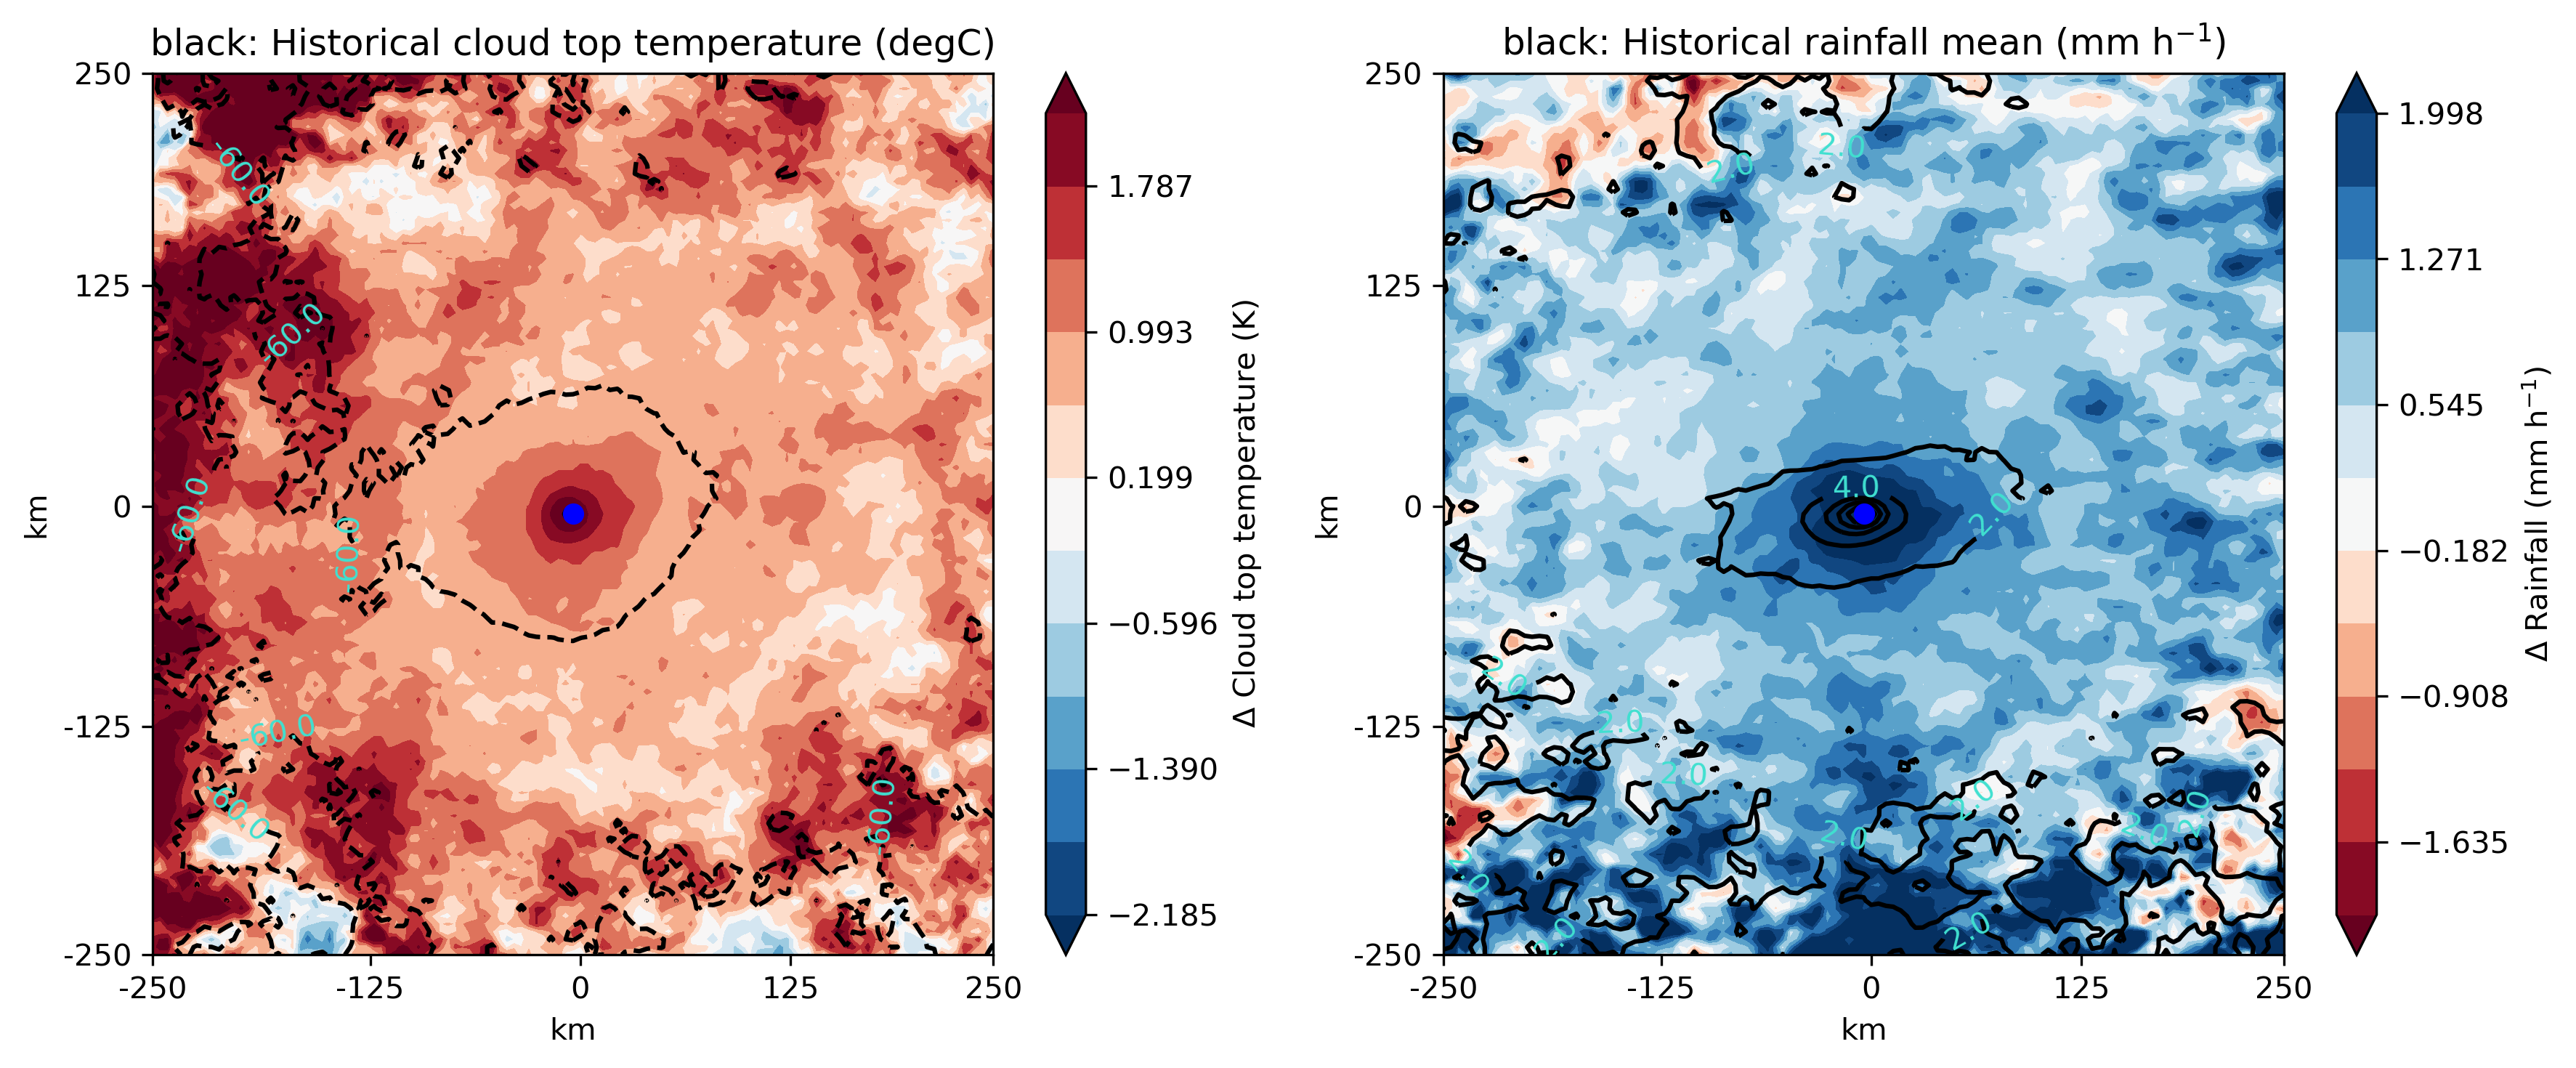

In [353]:
f = plt.figure(figsize=(12,5), dpi=300)
mname = 'node'
extent = 57 #* 4.4

ticks = np.array([0,58-57/2,58,58+57/2,114])
#labels = np.rint([-57*4.4,-57/2*4.4,0,57/2*4.4, 57*4.4])
labels = [-250,-125,0,125,250]

ax = f.add_subplot(1,2,1)

ano =da_fut['lw_out_PBLtop']-da_hist['lw_out_PBLtop']
cont = da_hist['lw_out_PBLtop']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='RdBu_r', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='$\Delta$ Cloud top temperature (K)')
plt.title('black: Historical cloud top temperature (degC)')
cm = ax.contour(cont, colors='k', levels=[-80, -70, -60], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = f.add_subplot(1,2,2)
ano =(da_fut['lsRain']-da_hist['lsRain'])
cont = da_hist['lsRain']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='RdBu', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='$\Delta$ Rainfall (mm h$^{-1}$)')
plt.title('black: Historical rainfall mean (mm h$^{-1}$)')
cm = ax.contour(cont, colors='k', levels=[2,4,6,8,10,12], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')

# pv, pw = da_hist_anom['u_srfc'].values, da_hist_anom['v_srfc'].values
# qv = plt.quiver(np.arange(da_hist.longitude.shape[0])[::10], np.arange(da_hist.latitude.shape[0])[::10], pv[::10,::10], pw[::10,::10])

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

plt.tight_layout()

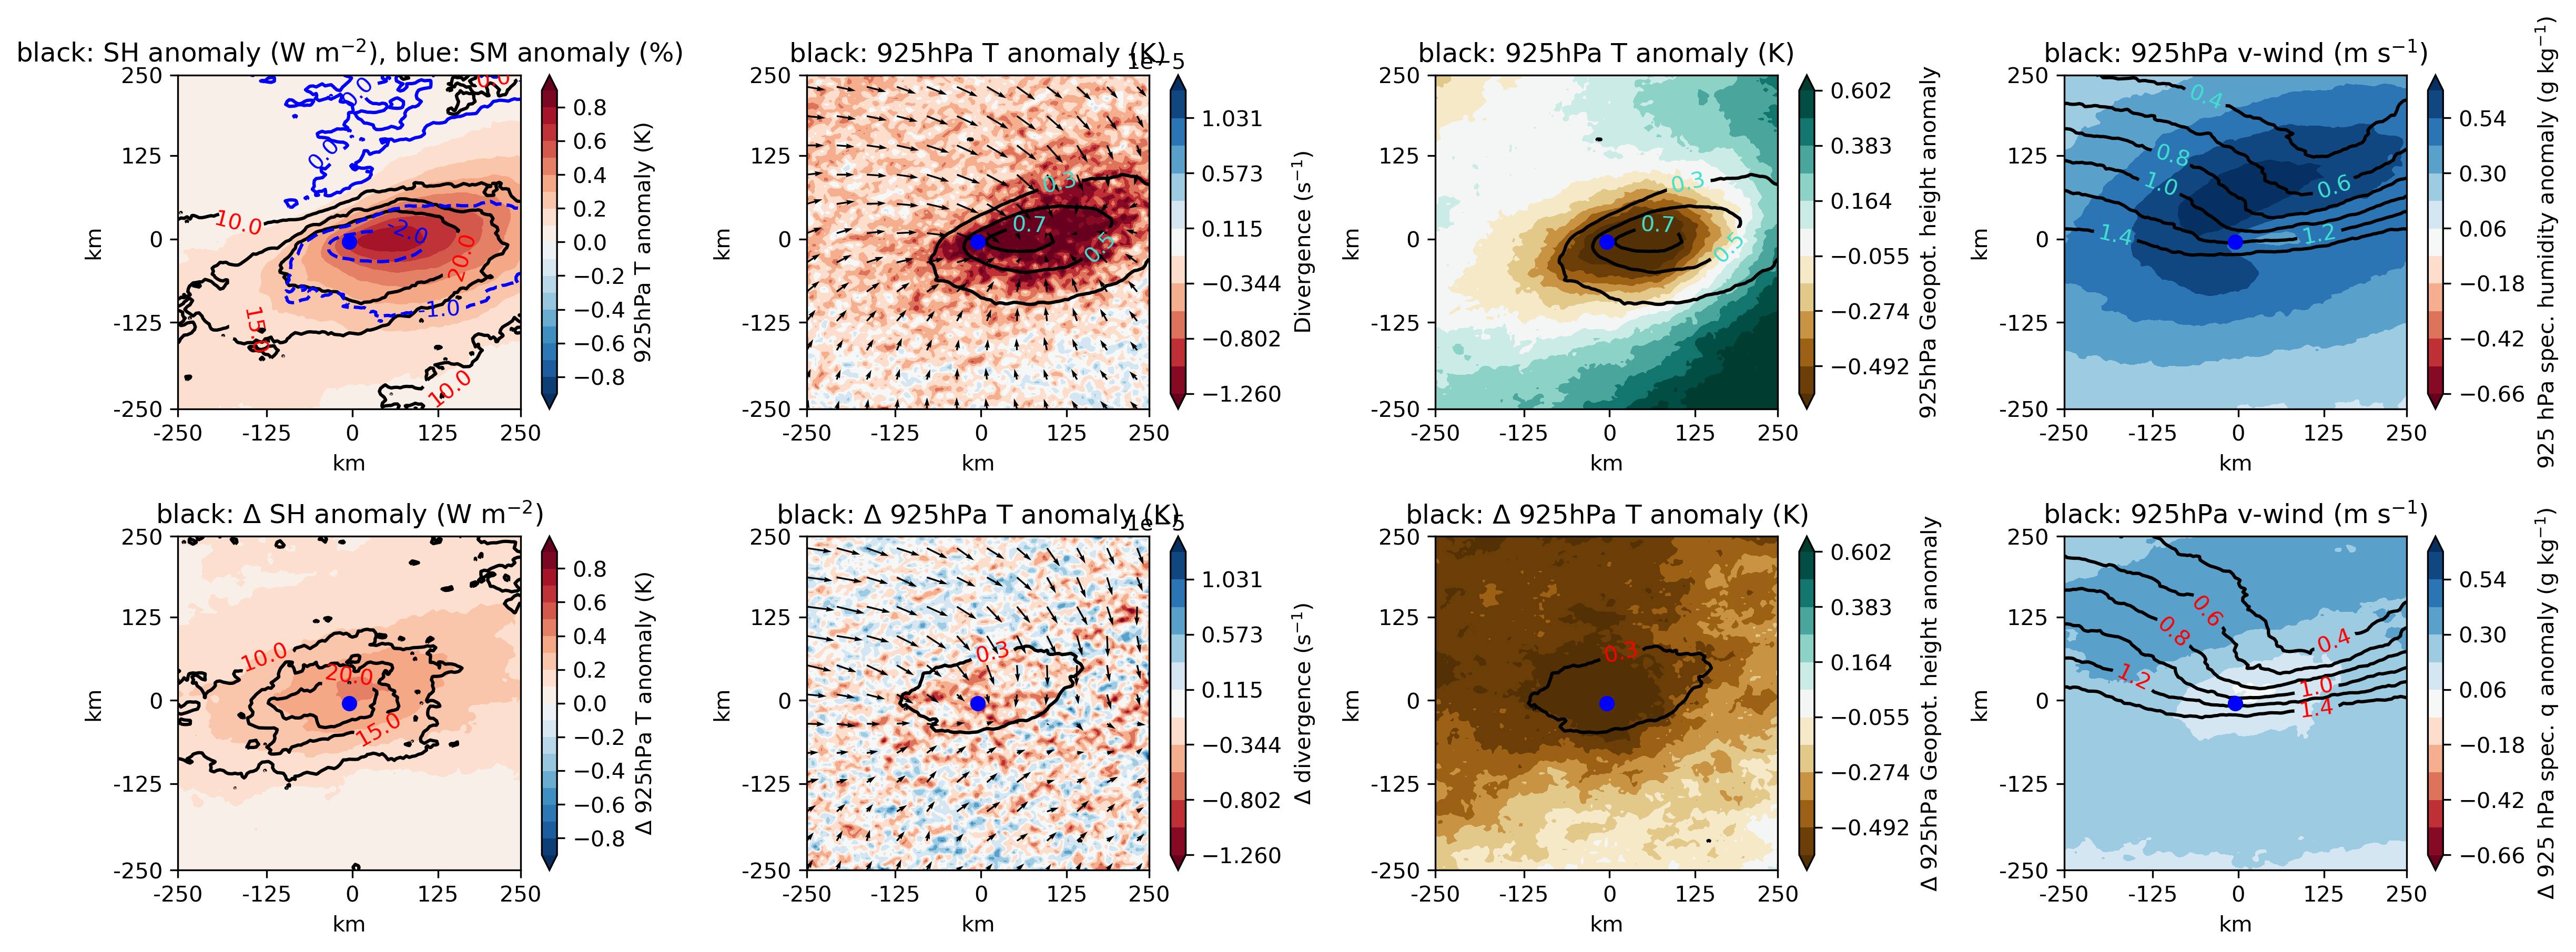

In [14]:
f = plt.figure(figsize=(16,6), dpi=300)
mname = 'node'
extent = 57 #* 4.4

ticks = np.array([0,58-57/2,58,58+57/2,114])
#labels = np.rint([-57*4.4,-57/2*4.4,0,57/2*4.4, 57*4.4])
labels = [-250,-125,0,125,250]

ax = f.add_subplot(2,4,1)

#ano = da_hist_anom['t2']#.mean('cases')
cont =da_hist_anom['sh']
cont2 = da_hist_anom['SM']
ano = da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='RdBu_r', extend='both', levels=np.arange(-0.9,0.91,0.1)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='925hPa T anomaly (K)')
plt.title('black: SH anomaly (W m$^{-2}$), blue: SM anomaly (%)')
cm = ax.contour(cont, colors='k', levels=[-20,-15,-10,0,10,15,20], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')

cm = ax.contour(cont2, colors='blue', levels=[-2,-1,0,1,2], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='blue')

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = f.add_subplot(2,4,2)
ano_div = calc_div(da_hist)
cont = da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano_div, [5, 95])))

plt.contourf(ano_div, cmap='RdBu', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='Divergence (s$^{-1}$)')
plt.title('black: 925hPa T anomaly (K)')
cm = ax.contour(cont, colors='k', levels=[-0.9, -0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')

pv, pw = da_hist_anom['u_srfc'].values, da_hist_anom['v_srfc'].values
qv = plt.quiver(np.arange(da_hist.longitude.shape[0])[::10], np.arange(da_hist.latitude.shape[0])[::10], pv[::10,::10], pw[::10,::10])

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = f.add_subplot(2,4,4)
ano = da_hist_anom['q_srfc']
cont = da_hist['v_srfc']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='RdBu', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='925 hPa spec. humidity anomaly (g kg$^{-1}$)')
plt.title('black: 925hPa v-wind (m s$^{-1}$)')
cm = ax.contour(cont, colors='k', levels=[-1.4,-1.2,-1, -0.8, -0.6,-0.4,0,0.4,0.6,0.8,1,1.2,1.4], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)




ax = f.add_subplot(2,4,3)
ano = da_hist_anom['geoH_srfc']#*10
cont = da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='BrBG', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label=r'925hPa Geopot. height anomaly')
plt.title('black: 925hPa T anomaly (K)')
cm = ax.contour(cont, colors='k', levels=[-0.9, -0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='turquoise')


plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)



###############################################

ax = f.add_subplot(2,4,5)

#ano = da_hist_anom['t2']#.mean('cases')
cont =da_fut_anom['sh']-da_hist_anom['sh']

ano = da_fut_anom['t_srfc']-da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano, [5, 95])))

plt.contourf(ano, cmap='RdBu_r', extend='both', levels=np.arange(-0.9,0.91,0.1))  #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='$\Delta$ 925hPa T anomaly (K)')
plt.title('black: $\Delta$ SH anomaly (W m$^{-2}$)')
cm = ax.contour(cont, colors='k', levels=[-20,-15,-10,0, 10,15,20], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')


plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = f.add_subplot(2,4,6)

ano = calc_div(da_hist)
anofut = calc_div(da_fut)
ano = anofut-ano
cont = da_fut_anom['t_srfc']-da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(ano_div, [5, 95])))

plt.contourf(ano, cmap='RdBu', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='$\Delta$ divergence (s$^{-1}$)')
plt.title('black: $\Delta$ 925hPa T anomaly (K)')
cm = ax.contour(cont, colors='k', levels=[-0.9,-0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')

pv, pw = da_fut_anom['u_srfc'].values-da_hist_anom['u_srfc'].values, da_fut_anom['v_srfc'].values-da_hist_anom['v_srfc'].values
qv = plt.quiver(np.arange(da_hist.longitude.shape[0])[::10], np.arange(da_hist.latitude.shape[0])[::10], pv[::10,::10], pw[::10,::10])

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = f.add_subplot(2,4,8)
pano = da_hist_anom['q_srfc']
ano = da_fut_anom['q_srfc']-da_hist_anom['q_srfc']
cont = da_fut['v_srfc']

thresh = np.max(np.abs(np.percentile(pano, [5, 95])))

plt.contourf(ano, cmap='RdBu', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label='$\Delta$ 925 hPa spec. q anomaly (g kg$^{-1}$)')
plt.title('black: 925hPa v-wind (m s$^{-1}$)')
cm = ax.contour(cont, colors='k', levels=[-1.4,-1.2,-1, -0.8, -0.6,-0.4,0,0.4,0.6,0.8,1,1.2,1.4], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')

plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)


ax = f.add_subplot(2,4,7)
pano = da_hist_anom['geoH_srfc']
ano = (da_fut_anom['geoH_srfc']-da_hist_anom['geoH_srfc'])#*10
cont = da_fut_anom['t_srfc']-da_hist_anom['t_srfc']

thresh = np.max(np.abs(np.percentile(pano, [5, 95])))

plt.contourf(ano, cmap='BrBG', extend='both', levels=np.linspace(thresh * -1, thresh, 12)) #levels=np.linspace(thresh * -1, thresh, 10)
plt.colorbar(label=r'$\Delta$ 925hPa Geopot. height anomaly')
plt.title('black: $\Delta$ 925hPa T anomaly (K)')
cm = ax.contour(cont, colors='k', levels=[-0.9, -0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9], linewidths=1.5)
ax.clabel(cm, inline=True, fontsize=10, fmt='%1.1f', colors='r')


plt.plot(extent, extent, 'bo')
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)



plt.tight_layout()
f.savefig(cnst.network_data + 'figs/LMCS/CP4_PNASstudy/composites_hist_fut_poster.jpg')

In [358]:
dic

{'lw_out_PBLtop': [],
 'lsRain': [],
 'shear': [],
 'u_mid': [],
 'u_srfc': [],
 'v_mid': [],
 'v_srfc': [],
 'q_mid': [],
 't_mid': [],
 't_srfc': [],
 'q_srfc': [],
 'geoH_srfc': [],
 'tcwv': [],
 'sh': [],
 'lh': [],
 't2': [],
 'q2': [],
 'lsRain_noon': [],
 'lwout_noon': [],
 'SM': []}

In [379]:
fh = glob.glob('/home/ck/DIR/cornkle/data/LMCS/MCS_files/CP4_box/CP4_allHours_historical_5000km2_-50_WAf_box_v2/*.nc')
dic = {}
dummy = xr.open_dataset(fh[0])
for vn in dummy.data_vars:
    dic[vn] = []

for ffh in fh:
    ds = xr.open_dataset(ffh)
    for vn in ds.data_vars:
        
        da = ds[vn].sel(latitude=slice(-11,11), longitude=slice(-11,11)).count(['longitude','latitude'])
        #ipdb.set_trace()
        if da > 0.25*(22*22):
            da =  float(ds[vn].sel(latitude=slice(-11,11), longitude=slice(-11,11)).mean(['longitude','latitude']).values)
        else:
            da = np.nan
        
        dic[vn].append(float(da))
df = pd.DataFrame.from_dict(dic, orient="index")
df.to_csv('/home/ck/DIR/cornkle/data/LMCS/MCS_files/CP4_box/hist_table_1700.csv')

In [380]:
fh = glob.glob('/home/ck/DIR/cornkle/data/LMCS/MCS_files/CP4_box/CP4_allHours_future_5000km2_-50_WAf_box_v2/*.nc')
dic = {}
dummy = xr.open_dataset(fh[0])
for vn in dummy.data_vars:
    dic[vn] = []

for ffh in fh:
    ds = xr.open_dataset(ffh)
    for vn in ds.data_vars:
        
        da = ds[vn].sel(latitude=slice(-11,11), longitude=slice(-11,11)).count(['longitude','latitude'])
        #ipdb.set_trace()
        if da > 0.25*(22*22):
            da =  float(ds[vn].sel(latitude=slice(-11,11), longitude=slice(-11,11)).mean(['longitude','latitude']).values)
        else:
            da = np.nan
        
        dic[vn].append(float(da))
df = pd.DataFrame.from_dict(dic, orient="index")
df.to_csv('/home/ck/DIR/cornkle/data/LMCS/MCS_files/CP4_box/fut_table_1700.csv')

In [16]:
from endgame import hist2d
lhist = pd.read_csv('/home/ck/DIR/cornkle/data/LMCS/MCS_files/CP4_box/hist_table_1700.csv', index_col=0).transpose()
lfut =  pd.read_csv('/home/ck/DIR/cornkle/data/LMCS/MCS_files/CP4_box/fut_table_1700.csv', index_col=0).transpose()

In [17]:
lhist['EF'] = (lhist['lh'] / (lhist['lh']+lhist['sh']))
lfut['EF'] = (lfut['lh'] / (lfut['lh']+lfut['sh']))

In [18]:
lhist['Tdiff'] = (lhist['t2']-273.15) - lhist['t_srfc']
lfut['Tdiff'] = (lfut['t2']-273.15) - lfut['t_srfc']

In [19]:
lhist['Tdiff']

0       7.519617
1       6.438149
2       5.111976
3       4.648180
4       3.791438
          ...   
9674    7.150464
9675    4.918847
9676    1.783607
9677    6.320018
9678    5.722718
Name: Tdiff, Length: 9679, dtype: float64

In [20]:
var = 'EF'
cp4 = hist2d.basic_1d_binning(lhist[var], np.arange(np.min(lhist[var]), np.max(lhist[var]),0.01))
cp4f = hist2d.basic_1d_binning(lfut[var], np.arange(np.min(lfut[var]), np.max(lfut[var]),0.01))

In [21]:
def calc_theta_table(da):    
    p = units.Quantity(925, 'hPa')
    
   # ipdb.set_trace()
    t = units.Quantity(da['t_srfc'].values+273.15, 'K')
    q = units.Quantity(da['q_srfc'].values/1000, 'kg/kg')
    
    p_up = units.Quantity(650, 'hPa')
    t_up = units.Quantity(da['t_mid'].values+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p_up,t_up))
    
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
     
    thetae = thetae_down -thetaes_up 
    
    return thetae

In [22]:
lhist['cape'] = calc_theta_table(lhist)

In [23]:
lfut['cape'] = calc_theta_table(lfut)

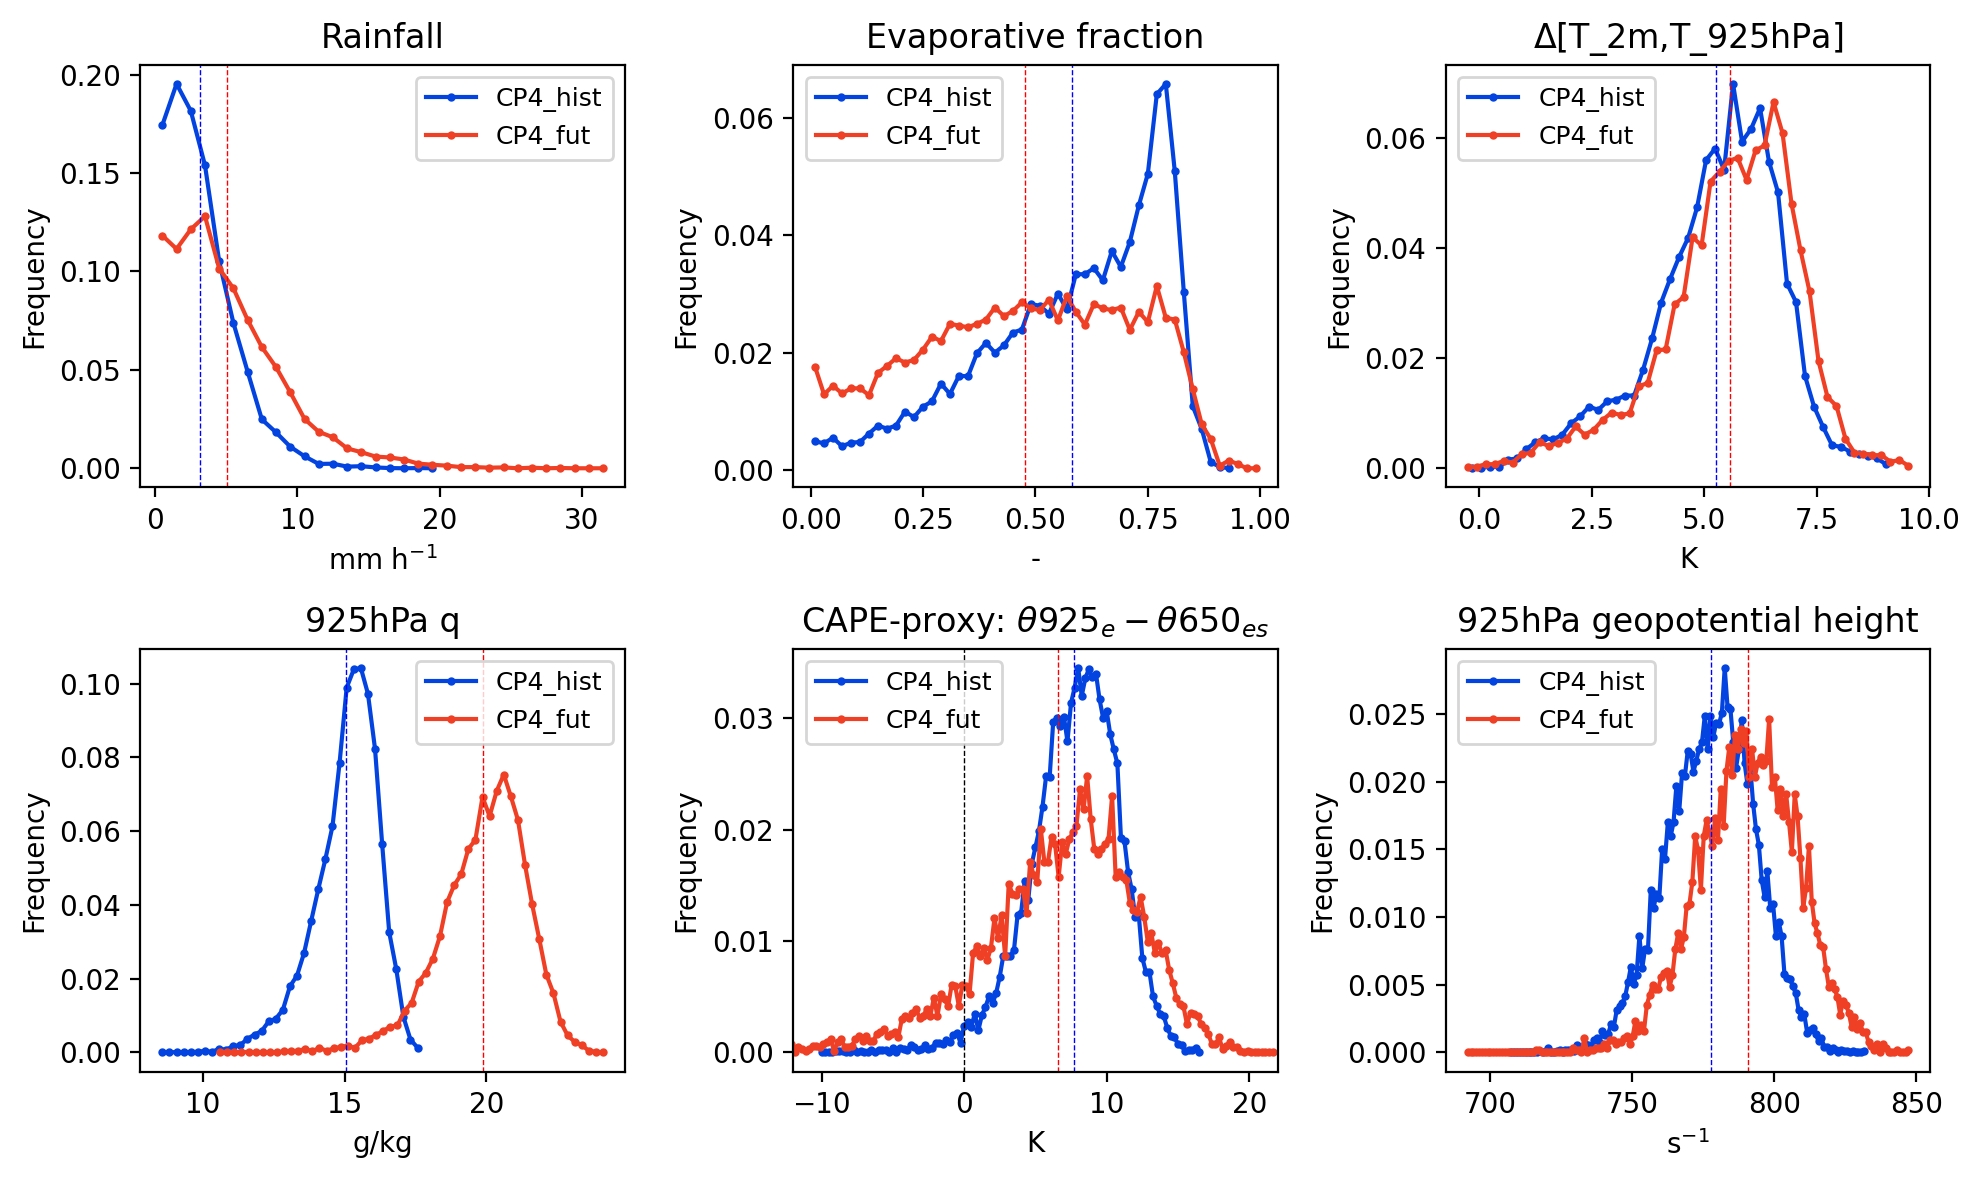

In [28]:
f = plt.figure(figsize=(10,6), dpi=200)



ax = f.add_subplot(231)

var = 'lsRain'
cp4 = hist2d.basic_1d_binning(lhist[var], np.arange(np.min(lhist[var]), np.max(lhist[var]),1))
cp4f = hist2d.basic_1d_binning(lfut[var], np.arange(np.min(lfut[var]), np.max(lfut[var]),1))
plt.plot(cp4['xbins'], cp4['nb']/np.sum(cp4['nb']), color='xkcd:blue', label='CP4_hist', marker='o', markersize=2)
plt.plot(cp4f['xbins'], cp4f['nb']/np.sum(cp4f['nb']), color='xkcd:tomato', label='CP4_fut', marker='o', markersize=2)
plt.ylabel('Frequency')
plt.xlabel('mm h$^{-1}$')
plt.title('Rainfall')
ax.axvline(lhist[var].mean(), color='b', linestyle='dashed', linewidth=0.5)
ax.axvline(lfut[var].mean(), color='r', linestyle='dashed', linewidth=0.5)
plt.legend(fontsize=9)


ax = f.add_subplot(232)

var = 'EF'
cp4 = hist2d.basic_1d_binning(lhist[var], np.arange(np.min(lhist[var]), np.max(lhist[var]),0.02))
cp4f = hist2d.basic_1d_binning(lfut[var], np.arange(np.min(lfut[var]), np.max(lfut[var]),0.02))
plt.plot(cp4['xbins'], cp4['nb']/np.sum(cp4['nb']), color='xkcd:blue', label='CP4_hist', marker='o', markersize=2)
plt.plot(cp4f['xbins'], cp4f['nb']/np.sum(cp4f['nb']), color='xkcd:tomato', label='CP4_fut', marker='o', markersize=2)
plt.ylabel('Frequency')
plt.xlabel('-')
plt.title('Evaporative fraction')
ax.axvline(lhist[var].mean(), color='b', linestyle='dashed', linewidth=0.5)
ax.axvline(lfut[var].mean(), color='r', linestyle='dashed', linewidth=0.5)
plt.legend(fontsize=9)


ax = f.add_subplot(233)

var = 'Tdiff'
cp4 = hist2d.basic_1d_binning(lhist[var], np.arange(np.min(lhist[var]), np.max(lhist[var]),0.2))
cp4f = hist2d.basic_1d_binning(lfut[var], np.arange(np.min(lfut[var]), np.max(lfut[var]),0.2))
plt.plot(cp4['xbins'], cp4['nb']/np.sum(cp4['nb']), color='xkcd:blue', label='CP4_hist', marker='o', markersize=2)
plt.plot(cp4f['xbins'], cp4f['nb']/np.sum(cp4f['nb']), color='xkcd:tomato', label='CP4_fut', marker='o', markersize=2)
plt.ylabel('Frequency')
plt.xlabel('K')
plt.title('$\Delta$[T_2m,T_925hPa]')
ax.axvline(lhist[var].mean(), color='b', linestyle='dashed', linewidth=0.5)
ax.axvline(lfut[var].mean(), color='r', linestyle='dashed', linewidth=0.5)
plt.legend(fontsize=9)



ax = f.add_subplot(234)

var = 'q_srfc'
cp4 = hist2d.basic_1d_binning(lhist[var], np.arange(np.min(lhist[var]), np.max(lhist[var]),0.25))
cp4f = hist2d.basic_1d_binning(lfut[var], np.arange(np.min(lfut[var]), np.max(lfut[var]),0.25))
plt.plot(cp4['xbins'], cp4['nb']/np.sum(cp4['nb']), color='xkcd:blue', label='CP4_hist', marker='o', markersize=2)
plt.plot(cp4f['xbins'], cp4f['nb']/np.sum(cp4f['nb']), color='xkcd:tomato', label='CP4_fut', marker='o', markersize=2)
plt.ylabel('Frequency')
plt.xlabel('g/kg')
plt.title('925hPa q')
ax.axvline(lhist[var].mean(), color='b', linestyle='dashed', linewidth=0.5)
ax.axvline(lfut[var].mean(), color='r', linestyle='dashed', linewidth=0.5)
plt.legend(fontsize=9)


ax = f.add_subplot(235)
ax.set_xlim(-12,22)
thet_hist = calc_theta_table(lhist)
thet_fut = calc_theta_table(lfut)
#ipdb.set_trace()
cp4 = hist2d.basic_1d_binning(thet_hist, np.arange(np.nanmin(thet_hist), np.nanmax(thet_hist),0.25))
cp4f = hist2d.basic_1d_binning(thet_fut, np.arange(np.nanmin(thet_fut), np.nanmax(thet_fut),0.25))
plt.plot(cp4['xbins'], cp4['nb']/np.sum(cp4['nb']), color='xkcd:blue', label='CP4_hist', marker='o', markersize=2)
plt.plot(cp4f['xbins'], cp4f['nb']/np.sum(cp4f['nb']), color='xkcd:tomato', label='CP4_fut', marker='o', markersize=2)
plt.ylabel('Frequency')
plt.xlabel(r'K')
plt.title(r'CAPE-proxy: $\theta925 _{e}-\theta650 _{es}$')
ax.axvline(np.nanmean(thet_hist), color='b', linestyle='dashed', linewidth=0.5)
ax.axvline(np.nanmean(thet_fut), color='r', linestyle='dashed', linewidth=0.5)
plt.legend(fontsize=9)
ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
plt.tight_layout()


ax = f.add_subplot(236)
var = 'geoH_srfc'
cp4 = hist2d.basic_1d_binning(lhist[var], np.arange(np.min(lhist[var]), np.max(lhist[var]),1))
cp4f = hist2d.basic_1d_binning(lfut[var], np.arange(np.min(lfut[var]), np.max(lfut[var]),1))
plt.plot(cp4['xbins'], cp4['nb']/np.sum(cp4['nb']), color='xkcd:blue', label='CP4_hist', marker='o', markersize=2)
plt.plot(cp4f['xbins'], cp4f['nb']/np.sum(cp4f['nb']), color='xkcd:tomato', label='CP4_fut', marker='o', markersize=2)
plt.ylabel('Frequency')
plt.xlabel(r's$^{-1}$')
plt.title(r'925hPa geopotential height')
ax.axvline(lhist[var].mean(), color='b', linestyle='dashed', linewidth=0.5)
ax.axvline(lfut[var].mean(), color='r', linestyle='dashed', linewidth=0.5)
plt.legend(fontsize=9)
plt.tight_layout()

f.savefig(cnst.network_data + 'figs/LMCS/CP4_PNASstudy/raw_variable_distributions_100km-Box.jpg')

In [546]:
import scipy.stats as stats
from scipy.stats import gaussian_kde, linregress
def calc_density(v1,v2):

    xy = np.vstack([v1, v2])

    z = gaussian_kde(xy)(xy)

    return z / (z.max() - z.min())

# cp4s = [lhist[var2], lhist[var]] 
# finites = np.isfinite(cp4s[0])&np.isfinite(cp4s[1])
# cp4s = [(cp4s[0])[finites],(cp4s[1])[finites]]
# r = stats.pearsonr(cp4s[0], cp4s[1])
# density = calc_density(cp4s[0], cp4s[1])
# plt.scatter(cp4s[0], cp4s[1], c=density, cmap='viridis')

# cp4s = [lfut[var2], lfut[var]] 
# finites = np.isfinite(cp4s[0])&np.isfinite(cp4s[1])
# cp4s = [(cp4s[0])[finites],(cp4s[1])[finites]]
# r = stats.pearsonr(cp4s[0], cp4s[1])
# density = calc_density(cp4s[0], cp4s[1])
# plt.scatter(cp4s[0], cp4s[1], c=density, cmap='inferno', alpha=0.3)

In [589]:
from scipy.stats import binned_statistic
def binning(dic, var1, var2, bins):
    func = lambda y: np.nanmean(y)   #  could also be np.percentile(y, 95) etc.
    #func = lambda y: np.nanpercentile(y, 95)  #  could also be np.percentile(y, 95) etc.
    dat, bin_edges, binnumber = binned_statistic(dic[var1], dic[var2], statistic=func, bins=bins)
    tcbins = bin_edges[0:-1] + (bin_edges[1::]-bin_edges[0:-1])/2
  #  ipdb.set_trace()
    pslope, pintercept, pr_value, pp_value, pstd_err = stats.linregress(tcbins[np.isfinite(dat)], dat[np.isfinite(dat)])

    return dat, tcbins, pslope, pintercept, pp_value

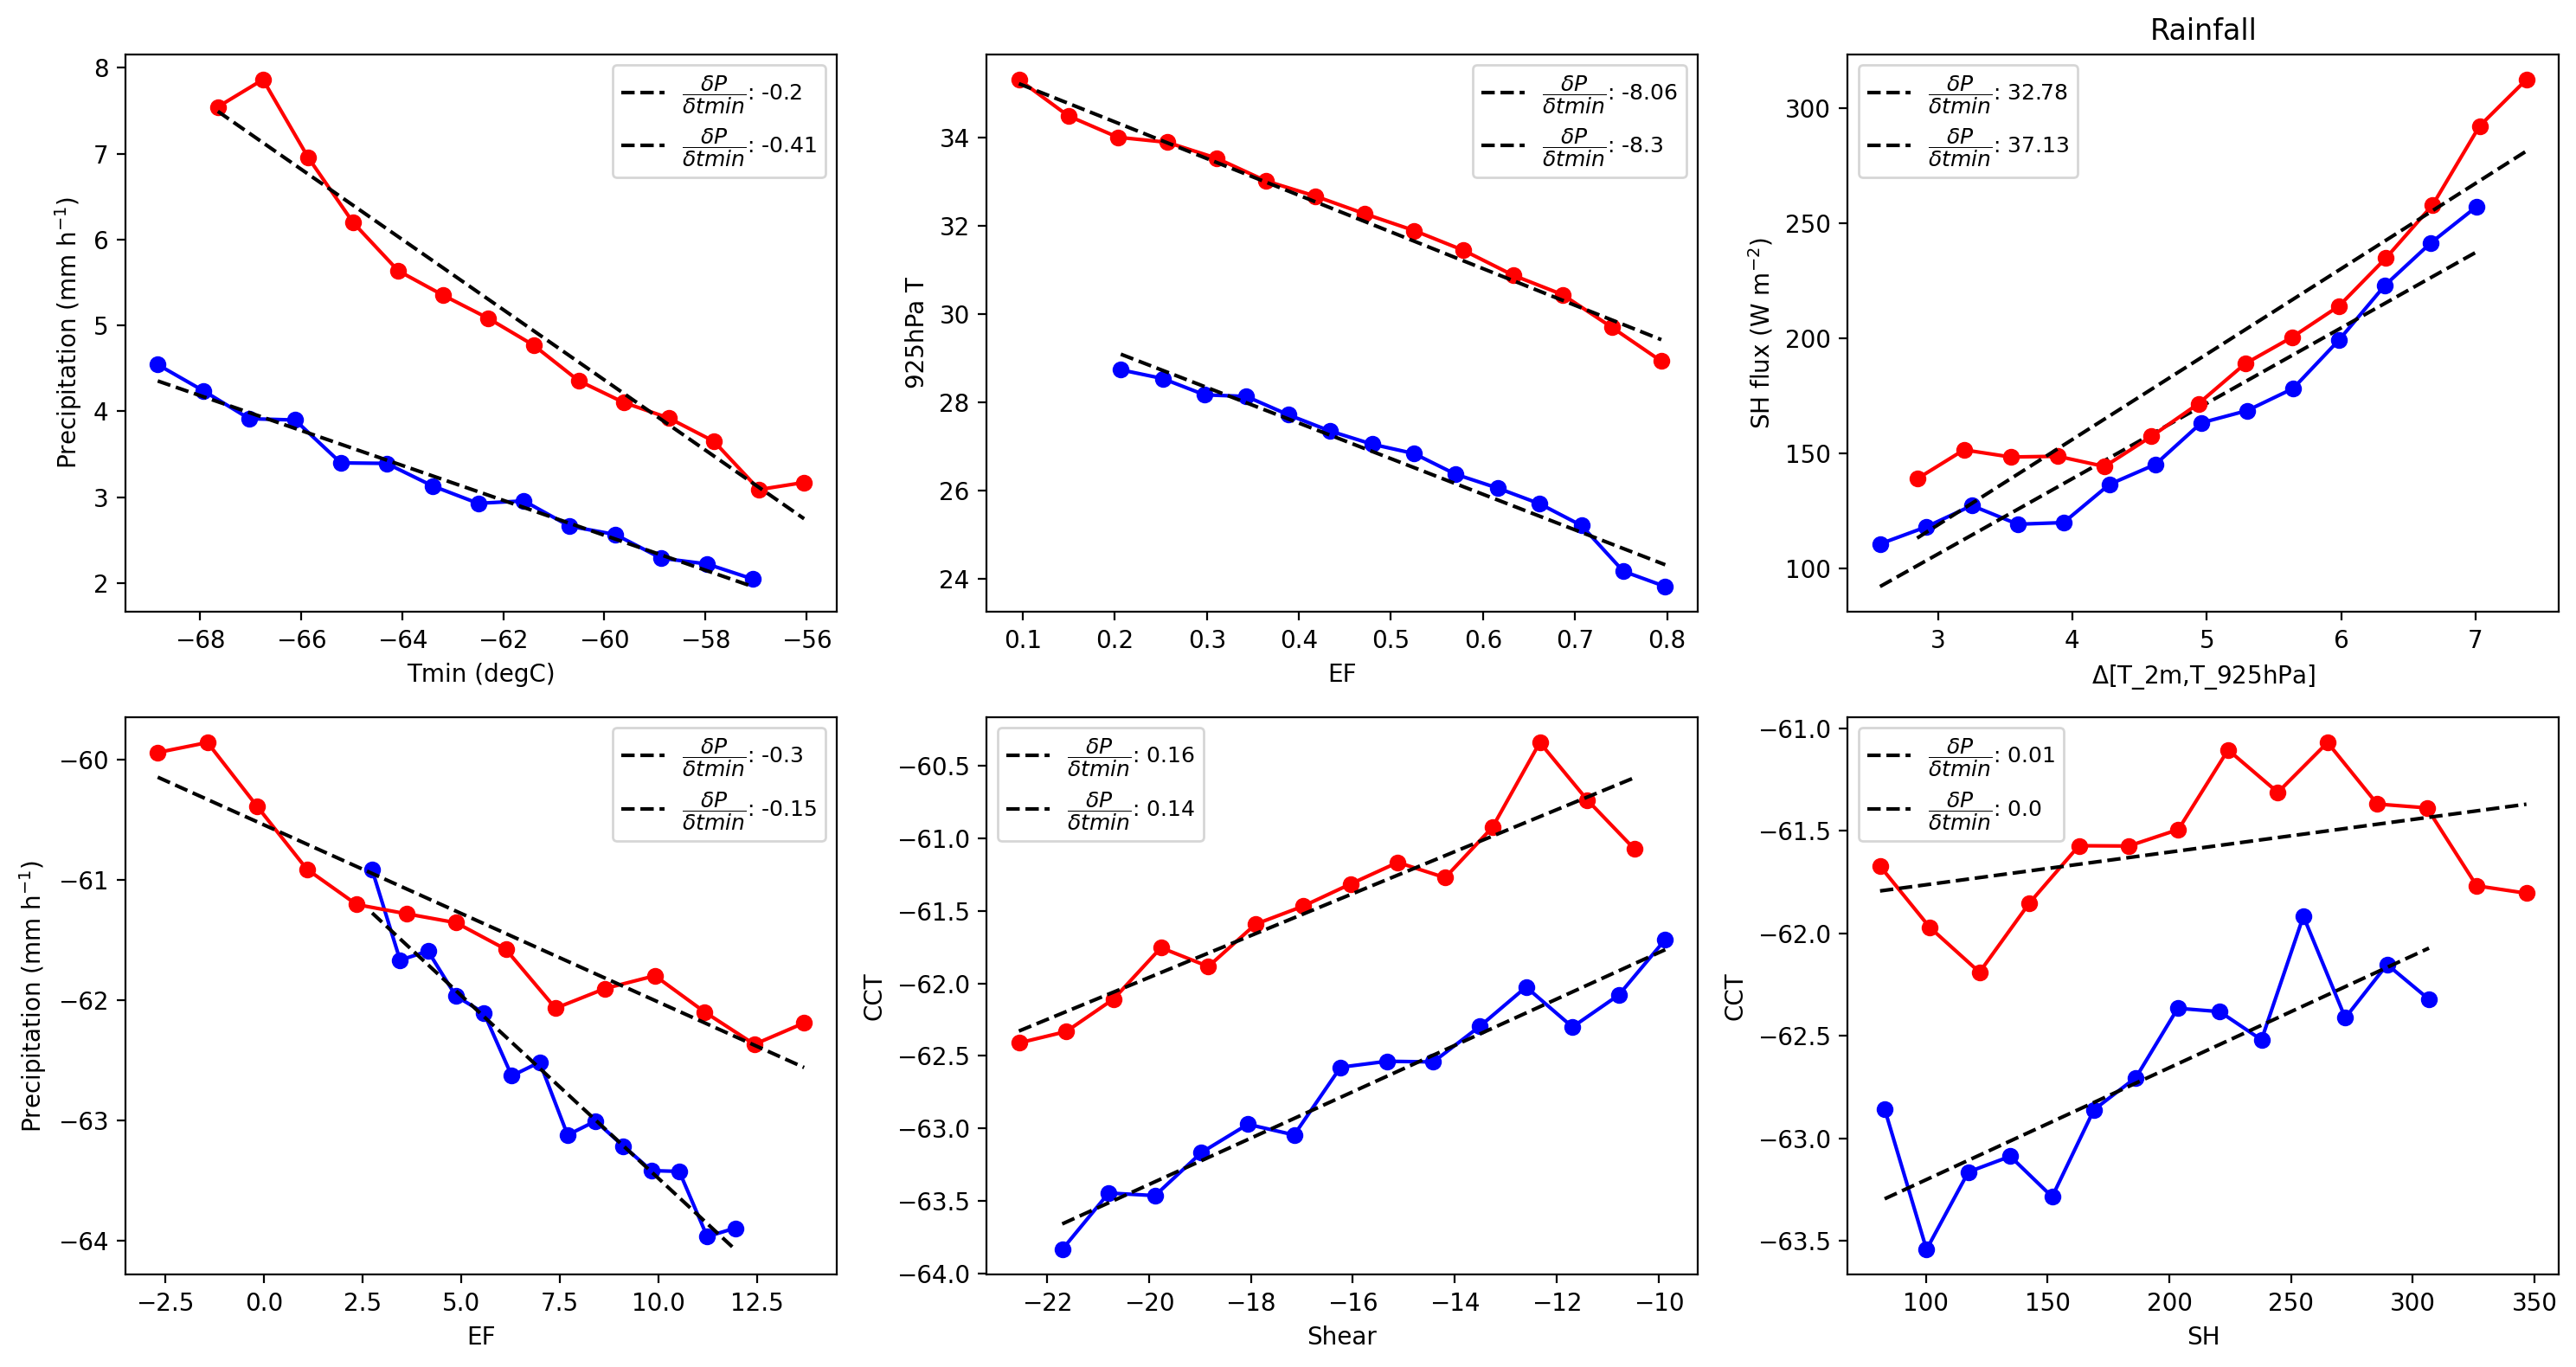

In [598]:
f = plt.figure(figsize=(15,8), dpi=200)
p1 = 5
p2 = 95
vals = 15

ax = f.add_subplot(231)
var1 = 'lw_out_PBLtop'
var2 = 'lsRain'
dat = lhist
binx = np.nanpercentile(dat[var1],[p1,p2])
bins = np.linspace(binx[0], binx[1], vals)
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='b', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

dat = lfut
binx = np.nanpercentile(dat[var1],[p1,p2])
bins = np.linspace(binx[0], binx[1], vals)
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='r', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

plt.xlabel('Tmin (degC)')
plt.ylabel('Precipitation (mm h$^{-1}$)')

plt.legend(fontsize=9)


ax = f.add_subplot(232)

var1 = 'EF'
var2 = 't_srfc'
dat = lhist
binx = np.nanpercentile(dat[var1],[p1,p2])
#ipdb.set_trace()
bins = np.linspace(binx[0], binx[1], vals)
#ipdb.set_trace()
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='b', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

dat = lfut
binx = np.nanpercentile(dat[var1],[p1,p2])
bins = np.linspace(binx[0], binx[1], vals)
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='r', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

plt.xlabel('EF')
plt.ylabel('925hPa T')

plt.legend(fontsize=9)


ax = f.add_subplot(233)

var1 = 'Tdiff'
var2 = 'sh'
dat = lhist
binx = np.nanpercentile(dat[var1],[p1,p2])
#ipdb.set_trace()
bins = np.linspace(binx[0], binx[1], vals)
#ipdb.set_trace()
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='b', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

dat = lfut
binx = np.nanpercentile(dat[var1],[p1,p2])
bins = np.linspace(binx[0], binx[1], vals)
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='r', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

plt.xlabel('$\Delta$[T_2m,T_925hPa]')
plt.ylabel('SH flux (W m$^{-2}$)')
plt.title('Rainfall')
plt.legend(fontsize=9)



ax = f.add_subplot(234)


var1 = 'cape'
var2 = 'lw_out_PBLtop'
dat = lhist
binx = np.nanpercentile(dat[var1],[p1,p2])
#ipdb.set_trace()
bins = np.linspace(binx[0], binx[1], vals)
#ipdb.set_trace()
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='b', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

dat = lfut
binx = np.nanpercentile(dat[var1],[p1,p2])
bins = np.linspace(binx[0], binx[1], vals)
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='r', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

plt.xlabel('EF')
plt.ylabel('Precipitation (mm h$^{-1}$)')

plt.legend(fontsize=9)

ax = f.add_subplot(235)

var1 = 'shear'
var2 = 'lw_out_PBLtop'
dat = lhist
binx = np.nanpercentile(dat[var1],[p1,p2])
#ipdb.set_trace()
bins = np.linspace(binx[0], binx[1], vals)
#ipdb.set_trace()
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='b', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

dat = lfut
binx = np.nanpercentile(dat[var1],[p1,p2])
bins = np.linspace(binx[0], binx[1], vals)
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='r', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

plt.xlabel('Shear')
plt.ylabel('CCT')

plt.legend(fontsize=9)


ax = f.add_subplot(236)

var1 = 'sh'
var2 = 'lw_out_PBLtop'
dat = lhist
binx = np.nanpercentile(dat[var1],[p1,p2])
#ipdb.set_trace()
bins = np.linspace(binx[0], binx[1], vals)
#ipdb.set_trace()
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='b', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

dat = lfut
binx = np.nanpercentile(dat[var1],[p1,p2])
bins = np.linspace(binx[0], binx[1], vals)
data, bins, slope, inter, pval = binning(dat, var1, var2, bins=bins)
plt.plot(bins, data, color='r', marker='o')
plt.plot(bins, inter+np.array(bins)*slope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tmin}$: ' + str(np.round(slope,2)))

plt.xlabel('SH')
plt.ylabel('CCT')

plt.legend(fontsize=9)


plt.tight_layout()

f.savefig(cnst.network_data + 'figs/LMCS/CP4_PNASstudy/scatter_100km-Box.jpg')